In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout, LayerNormalization, Attention, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



CODE to check if the Tensor Flow can see the GPU

In [2]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected by TensorFlow")

1 Physical GPUs, 1 Logical GPUs


List of Companies used in the dataset:

In [3]:
company_symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "SSNLF", "SONY", 
    "BBY", "COST", "WMT", "INTC", "AMD", "TXN", "QCOM", "AVGO", "T", 
    "VZ", "TMUS", "CSCO", "CRM", "ADBE", "ORCL", "NOW", "V", "MA", 
    "PYPL", "SQ", "TSLA", "GM", "F", "NIO", "RIVN", "JNJ", "PFE", 
    "MRNA", "GILD", "AMGN", "BA", "GE", "HON", "MMM", "CAT", "XOM", 
    "CVX", "NEE", "DUK", "SLB"
]

Load Data

In [4]:
df = pd.read_csv("data/AAPL.csv")
print(df.head())

   Unnamed: 0  1. open  2. high    3. low  4. close  5. volume
0  2024-06-04  194.635  195.320  193.0342    194.35   47471445
1  2024-06-03  192.900  194.990  192.5200    194.03   50080539
2  2024-05-31  191.440  192.570  189.9100    192.25   75158277
3  2024-05-30  190.760  192.180  190.6300    191.29   49947941
4  2024-05-29  189.610  192.247  189.5100    190.29   53068016


In [5]:
# Load all the data in the company_symbols list
data = {}
for symbol in company_symbols:
    df = pd.read_csv(f"data/{symbol}.csv")
    if symbol == 'AAPL':
        df = df.rename(columns={"Unnamed: 0": "Date",'1. open':'AAPL_1. open',"4. close":"AAPL_4. close"})
        df = df.drop(columns=['2. high','3. low','5. volume'])
    else:
        df = df.drop(columns=["Unnamed: 0",f"2. high",f"3. low",f"4. close",f"5. volume"])
        df = df.rename(columns={"1. open":f"{symbol}"})
    data[symbol] = df



In [6]:
combined_df = pd.concat(data.values(), axis=1)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

combined_df['Original_Date'] = combined_df['Date']
# Convert the datetime to timestamp (number of seconds since 1970-01-01)
combined_df['Date'] = (combined_df['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# Sort the DataFrame by 'Date' in ascending order
combined_df = combined_df.sort_values('Date', ascending=True)

# Reset the index of the DataFrame
combined_df = combined_df.reset_index(drop=True)
print(combined_df.head())

        Date  AAPL_1. open  AAPL_4. close   MSFT  GOOGL   AMZN  META   NVDA  \
0  941414400         80.00          77.62  93.25    NaN  68.06   NaN  21.75   
1  941500800         78.00          80.25  92.75    NaN  69.75   NaN  23.94   
2  941587200         81.62          81.50  92.94    NaN  68.19   NaN  26.00   
3  941673600         82.06          83.62  92.31    NaN  67.19   NaN  27.75   
4  941760000         84.62          88.31  91.81    NaN  64.75   NaN  30.00   

   SSNLF    SONY  ...      GE    HON    MMM    CAT    XOM    CVX    NEE  \
0    NaN  158.75  ...  133.63  57.00  95.13  55.31  74.06  90.56  50.19   
1    NaN  156.69  ...  129.69  57.62  94.75  55.38  74.37  91.25  50.00   
2    NaN  159.00  ...  132.88  56.00  94.63  56.75  74.62  89.94  49.81   
3    NaN  159.75  ...  132.50  56.88  94.88  56.75  73.69  89.06  49.44   
4    NaN  162.62  ...  133.19  56.00  95.50  55.00  73.00  88.75  49.19   

     DUK    SLB  Original_Date  
0  56.44  61.25     1999-11-01  
1  56.63

VISUALIZING THE DATA

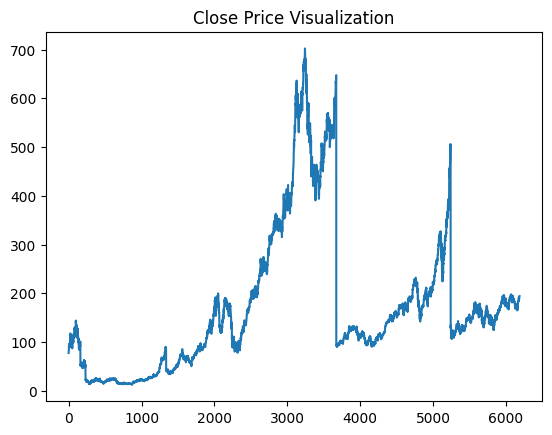

In [7]:
plt.title("Close Price Visualization")
plt.plot(combined_df['AAPL_4. close'], label='APPLE')

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

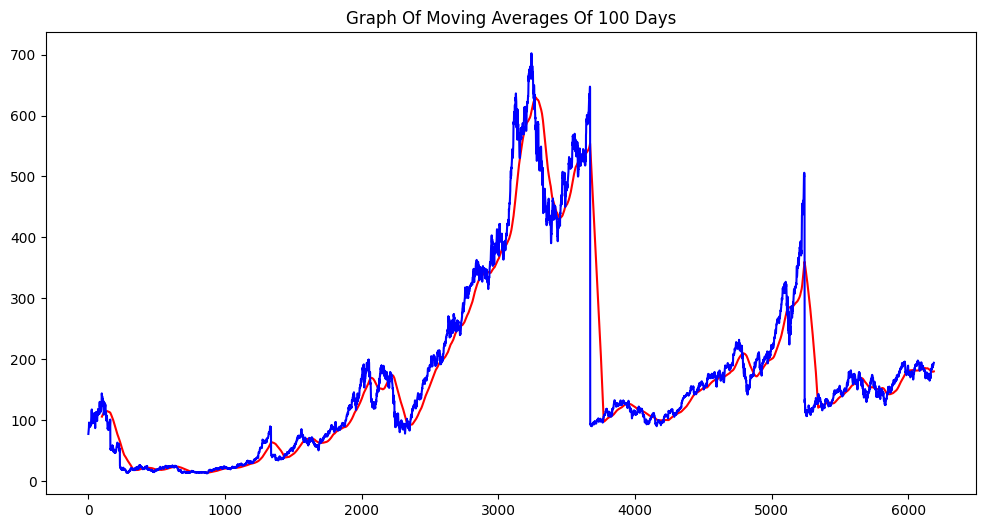

In [8]:
ma100 = combined_df['AAPL_4. close'].rolling(100).mean()
plt.figure(figsize = (12,6))
plt.plot(ma100, 'r')
plt.plot(combined_df['AAPL_4. close'], 'b')
plt.title('Graph Of Moving Averages Of 100 Days')

Text(0.5, 1.0, 'Graph Of Moving Averages Of 200 Days')

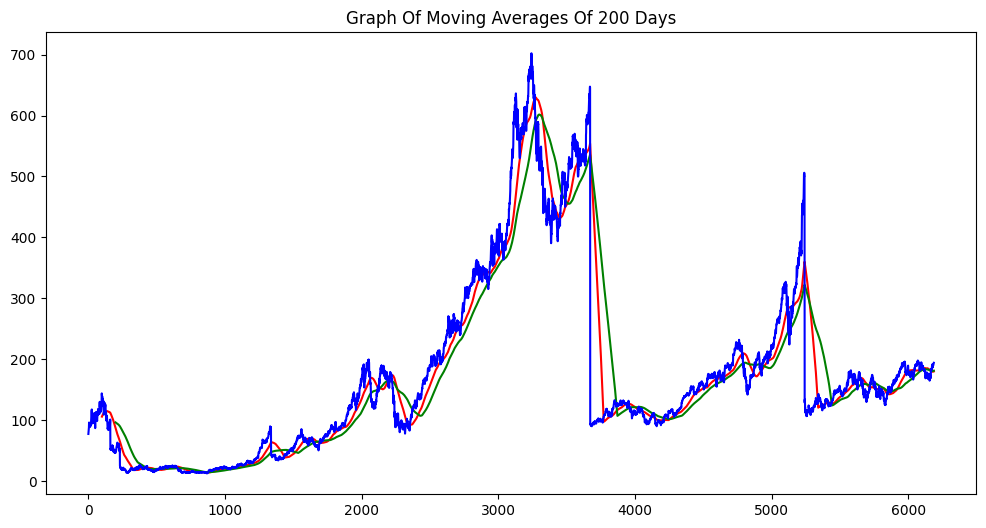

In [9]:
ma200 = combined_df['AAPL_4. close'].rolling(200).mean()
plt.figure(figsize = (12,6))
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.plot(combined_df['AAPL_4. close'], 'b')
plt.title('Graph Of Moving Averages Of 200 Days')

In [10]:
combined_df.to_csv("data/combined1.csv")

In [11]:
print(combined_df.tail())


            Date  AAPL_1. open  AAPL_4. close     MSFT   GOOGL    AMZN  \
6182  1716940800       189.610         190.29  425.690  175.43  181.70   
6183  1717027200       190.760         191.29  424.300  175.20  181.31   
6184  1717113600       191.440         192.25  416.750  171.86  178.30   
6185  1717372800       192.900         194.03  415.525  172.54  177.70   
6186  1717459200       194.635         194.35  412.430  173.28  177.64   

        META     NVDA    SSNLF   SONY  ...      GE     HON     MMM     CAT  \
6182  474.66  1130.50  40.5999  78.99  ...  166.60  197.83   97.80  345.00   
6183  471.67  1146.50  40.5999  80.48  ...  163.48  197.80   97.69  338.47   
6184  465.80  1125.20  40.5999  81.75  ...  164.29  200.33   98.06  339.34   
6185  470.86  1136.21  40.5999  83.13  ...  166.12  203.82  100.37  340.87   
6186  477.00  1157.16  40.5999  85.35  ...  161.00  201.06   99.00  328.71   

          XOM     CVX    NEE     DUK     SLB  Original_Date  
6182  114.525  158.02  7

HANDLING MISSING DATA

In [12]:
combined_df.isna().sum()

Date                0
AAPL_1. open        0
AAPL_4. close       0
MSFT                0
GOOGL            1205
AMZN                0
META             3157
NVDA                0
SSNLF             811
SONY                0
BBY                 0
COST                0
WMT                 0
INTC                0
AMD                 0
TXN                 0
QCOM                0
AVGO             2455
T                   0
VZ                  0
TMUS             1875
CSCO                0
CRM              1165
ADBE                0
ORCL                0
NOW              3186
V                2106
MA               1650
PYPL             3952
SQ               4039
TSLA             2680
GM               2780
F                   0
NIO              4746
RIVN             5543
JNJ                 0
PFE                 0
MRNA             4806
GILD                0
AMGN                0
BA                  0
GE                  0
HON                 0
MMM                 0
CAT                 0
XOM       

In [13]:
#delete columns with missing values 
combined_df = combined_df.dropna(axis=1)
combined_df.isna().sum()

Date             0
AAPL_1. open     0
AAPL_4. close    0
MSFT             0
AMZN             0
NVDA             0
SONY             0
BBY              0
COST             0
WMT              0
INTC             0
AMD              0
TXN              0
QCOM             0
T                0
VZ               0
CSCO             0
ADBE             0
ORCL             0
F                0
JNJ              0
PFE              0
GILD             0
AMGN             0
BA               0
GE               0
HON              0
MMM              0
CAT              0
XOM              0
CVX              0
NEE              0
DUK              0
SLB              0
Original_Date    0
dtype: int64

SPLITTING THE DATA INTO TRAINING AND TESTING SETS

In [14]:
data = combined_df
train = pd.DataFrame(data[0:int(len(data)*0.80)])
test = pd.DataFrame(data[int(len(data)*0.80): int(len(data))])

print(train.shape)
print(test.shape)

(4949, 35)
(1238, 35)


In [15]:
train_close = train[['AAPL_4. close']].values
test_close = test[['AAPL_4. close']].values

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_close)
data_training_array = scaler.fit_transform(train_close)
data_training_array


array([[0.09361665],
       [0.09743389],
       [0.09924816],
       ...,
       [0.27349125],
       [0.27520392],
       [0.27764231]])

In [17]:
x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [18]:
x_train.shape


(4849, 100, 1)

TRAINING THE MODEL

FIRST MODEL

In [19]:
# 5. Build the LSTM model
input_shape = (x_train.shape[1], 1)

model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=input_shape))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))


SECOND MODEL

In [20]:
model2 = Sequential()

model2.add(LSTM(60, return_sequences=True, activation='tanh', input_shape=input_shape))
model2.add(Dropout(0.1))

model2.add(LSTM(80, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(LSTM(100, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(LSTM(80, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(LSTM(40, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.1))

model2.add(Dense(1))


In [21]:

model3 = Sequential()
model3.add(LSTM(units = 50, activation = 'tanh', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model3.add(Dropout(0.2))


model3.add(LSTM(units = 60, activation = 'tanh', return_sequences=True))
model3.add(Dropout(0.3))


model3.add(LSTM(units = 80, activation = 'tanh', return_sequences=True))
model3.add(Dropout(0.4))


model3.add(LSTM(units = 120, activation = 'tanh'))
model3.add(Dropout(0.5))

model3.add(Dense(units = 1))


In [22]:
model4 = Sequential()
model4.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
model4.add(LayerNormalization())
model4.add(Dropout(0.2))

model4.add(Bidirectional(LSTM(50, return_sequences=True)))
model4.add(LayerNormalization())
model4.add(Dropout(0.2))

model4.add(Bidirectional(LSTM(50, return_sequences=True)))
model4.add(LayerNormalization())
model4.add(Dropout(0.2))

model4.add(Dense(25, activation='tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(1))


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 80)           26240     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           26200     
                                                                 
 lstm_2 (LSTM)               (None, 40)                14560     
                                                                 
 dense (Dense)               (None, 25)                1025      
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 68,701
Trainable params: 68,701
Non-traina

In [24]:
model2.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 60)           14880     
                                                                 
 dropout (Dropout)           (None, 100, 60)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_1 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 100)          72400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)          

In [25]:
model3.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_5 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_6 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_7 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

In [26]:
model4.compile(optimizer='adam', loss='mean_squared_error',metrics = ['MAE'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 100)         20800     
 l)                                                              
                                                                 
 layer_normalization (LayerN  (None, 100, 100)         200       
 ormalization)                                                   
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 100)         60400     
 nal)                                                            
                                                                 
 layer_normalization_1 (Laye  (None, 100, 100)         200       
 rNormalization)                                      

In [27]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 12s 35ms/step - loss: 0.0042 - MAE: 0.0270
Epoch 2/1000
152/152 [==============================] - 6s 41ms/step - loss: 0.0014 - MAE: 0.0190
Epoch 3/1000
152/152 [==============================] - 5s 36ms/step - loss: 0.0010 - MAE: 0.0151
Epoch 4/1000
152/152 [==============================] - 5s 34ms/step - loss: 7.8432e-04 - MAE: 0.0119
Epoch 5/1000
152/152 [==============================] - 5s 35ms/step - loss: 7.7670e-04 - MAE: 0.0131
Epoch 6/1000
152/152 [==============================] - 5s 35ms/step - loss: 7.1060e-04 - MAE: 0.0129
Epoch 7/1000
152/152 [==============================] - 5s 34ms/step - loss: 6.0853e-04 - MAE: 0.0127
Epoch 8/1000
152/152 [==============================] - 5s 36ms/step - loss: 5.3908e-04 - MAE: 0.0117
Epoch 9/1000
152/152 [==============================] - 5s 35ms/step - loss: 4.4855e-04 - MAE: 0.0099
Epoch 10/1000
152/152 [==============================] - 5s 35ms/step - loss: 4.1521e-04 - MA

In [28]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model2.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 19s 66ms/step - loss: 0.0586 - MAE: 0.1804
Epoch 2/1000
152/152 [==============================] - 10s 64ms/step - loss: 0.0569 - MAE: 0.1787
Epoch 3/1000
152/152 [==============================] - 9s 59ms/step - loss: 0.0564 - MAE: 0.1795
Epoch 4/1000
152/152 [==============================] - 9s 60ms/step - loss: 0.0565 - MAE: 0.1788
Epoch 5/1000
152/152 [==============================] - 9s 59ms/step - loss: 0.0563 - MAE: 0.1792
Epoch 6/1000
152/152 [==============================] - 9s 61ms/step - loss: 0.0563 - MAE: 0.1787
Epoch 7/1000
152/152 [==============================] - 9s 60ms/step - loss: 0.0563 - MAE: 0.1795
Epoch 8/1000
152/152 [==============================] - 10s 63ms/step - loss: 0.0562 - MAE: 0.1783
Epoch 9/1000
152/152 [==============================] - 9s 59ms/step - loss: 0.0562 - MAE: 0.1793
Epoch 10/1000
152/152 [==============================] - 9s 59ms/step - loss: 0.0562 - MAE: 0.1791
Epoch 11/1000
15

In [29]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model3.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 14s 52ms/step - loss: 0.0069 - MAE: 0.0450
Epoch 2/1000
152/152 [==============================] - 8s 50ms/step - loss: 0.0042 - MAE: 0.0373
Epoch 3/1000
152/152 [==============================] - 8s 50ms/step - loss: 0.0035 - MAE: 0.0324
Epoch 4/1000
152/152 [==============================] - 8s 51ms/step - loss: 0.0032 - MAE: 0.0307
Epoch 5/1000
152/152 [==============================] - 8s 56ms/step - loss: 0.0028 - MAE: 0.0292
Epoch 6/1000
152/152 [==============================] - 9s 56ms/step - loss: 0.0025 - MAE: 0.0275
Epoch 7/1000
152/152 [==============================] - 7s 49ms/step - loss: 0.0025 - MAE: 0.0280
Epoch 8/1000
152/152 [==============================] - 8s 51ms/step - loss: 0.0020 - MAE: 0.0253
Epoch 9/1000
152/152 [==============================] - 7s 48ms/step - loss: 0.0022 - MAE: 0.0265
Epoch 10/1000
152/152 [==============================] - 7s 48ms/step - loss: 0.0024 - MAE: 0.0271
Epoch 11/1000
152/

In [30]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model4.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

Epoch 1/1000
152/152 [==============================] - 22s 79ms/step - loss: 0.2305 - MAE: 0.3711
Epoch 2/1000
152/152 [==============================] - 13s 85ms/step - loss: 0.1059 - MAE: 0.2544
Epoch 3/1000
152/152 [==============================] - 14s 89ms/step - loss: 0.0809 - MAE: 0.2203
Epoch 4/1000
152/152 [==============================] - 13s 85ms/step - loss: 0.0697 - MAE: 0.2034
Epoch 5/1000
152/152 [==============================] - 12s 82ms/step - loss: 0.0651 - MAE: 0.1951
Epoch 6/1000
152/152 [==============================] - 12s 80ms/step - loss: 0.0617 - MAE: 0.1893
Epoch 7/1000
152/152 [==============================] - 12s 79ms/step - loss: 0.0600 - MAE: 0.1858
Epoch 8/1000
152/152 [==============================] - 13s 86ms/step - loss: 0.0589 - MAE: 0.1835
Epoch 9/1000
152/152 [==============================] - 13s 87ms/step - loss: 0.0580 - MAE: 0.1822
Epoch 10/1000
152/152 [==============================] - 15s 98ms/step - loss: 0.0576 - MAE: 0.1816
Epoch 11/

In [31]:
# Print the last date in the training data
print(combined_df.columns)

Index(['Date', 'AAPL_1. open', 'AAPL_4. close', 'MSFT', 'AMZN', 'NVDA', 'SONY',
       'BBY', 'COST', 'WMT', 'INTC', 'AMD', 'TXN', 'QCOM', 'T', 'VZ', 'CSCO',
       'ADBE', 'ORCL', 'F', 'JNJ', 'PFE', 'GILD', 'AMGN', 'BA', 'GE', 'HON',
       'MMM', 'CAT', 'XOM', 'CVX', 'NEE', 'DUK', 'SLB', 'Original_Date'],
      dtype='object')


In [32]:
model.save('keras_model.h5')
model2.save('keras_model2.h5')
model3.save('keras_model3.h5')
model4.save('keras_model4.h5')

In [33]:
test_close.shape
test_close

array([[204.23],
       [200.02],
       [201.24],
       ...,
       [192.25],
       [194.03],
       [194.35]])

In [34]:
past_100_days = pd.DataFrame(train_close[-100:])
test_df = pd.DataFrame(test_close)
final_df = pd.concat([past_100_days, test_df], ignore_index=True)
final_df = scaler.transform(final_df)


In [35]:
input_data = scaler.fit_transform(final_df)
input_data

input_data.shape

(1338, 1)

In [36]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)


(1238, 100, 1)
(1238,)


PREDICTIONS WITH THE FIRST MODEL

39/39 [==============================] - 6s 19ms/step


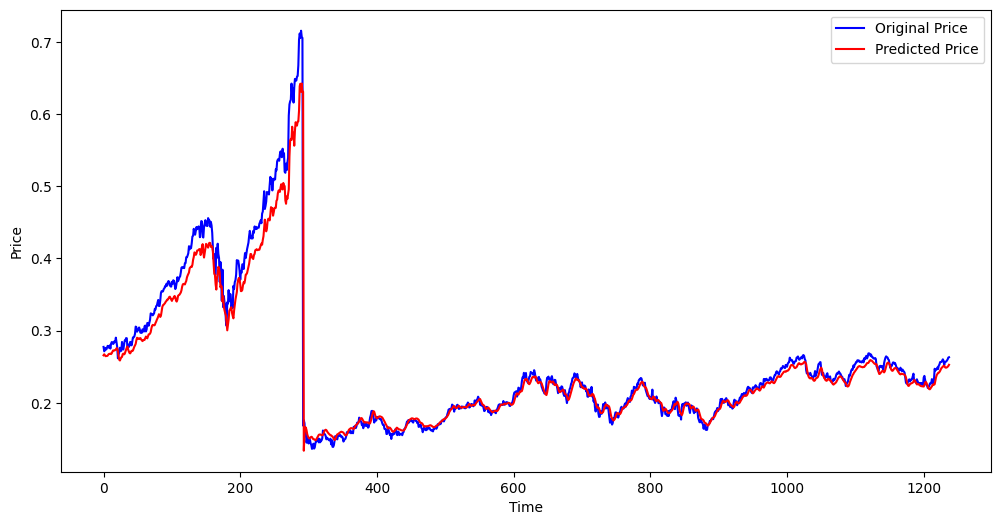

In [37]:
y_pred = model.predict(x_test)

scale_factor = 1/scaler.scale_
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)

The Mean Absolute Error is:  0.010948404921010287
The Mean Squared Error is:  0.00045929743677108984


In [39]:
y_pred = model2.predict(x_test)

scale_factor = 1/scaler.scale_
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

39/39 [==============================] - 6s 31ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)

In [ ]:
y_pred = model3.predict(x_test)

scale_factor = 1/scaler.scale_
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)

In [ ]:
y_pred = model4.predict(x_test)

scale_factor = 1/scaler.scale_
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Mean Absolute Error is: ", mae)
print("The Mean Squared Error is: ", mse)